In [1]:
### Chargement des données ###

import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

df = pd.DataFrame(columns=['<x>', '<y>','<z>','<t>','gesture', 'subject', 'iter'])

for subject in range(1,11):
    for number in range(0,10):
        for iteration in range(1,11):
            filename = 'Domain1_csv/Subject'+str(subject)+'-'+str(number)+'-'+str(iteration)+'.csv'
            file = pd.read_csv(filename)
            file['gesture'] = number
            file['subject'] = subject
            file['iter'] = iteration
            df = pd.concat([df, file])
df.columns = ['x', 'y', 'z', 't', 'gesture', 'subject', 'iter']

print(df)

C:\Users\VDB\AppData\Local\Temp\ipykernel_57252\3044230219.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, file])


            x         y         z       t gesture subject iter
0    0.042075  0.036799  0.258380     6.0       0       1    1
1    0.041904  0.037187  0.258505    37.0       0       1    1
2    0.041739  0.037219  0.258619    67.0       0       1    1
3    0.041446  0.037573  0.258731   101.0       0       1    1
4    0.041303  0.037331  0.258830   132.0       0       1    1
..        ...       ...       ...     ...     ...     ...  ...
114  0.126548 -0.070249  0.279681  3832.0       9      10   10
115  0.126768 -0.070271  0.279268  3861.0       9      10   10
116  0.126849 -0.070454  0.278912  3894.0       9      10   10
117  0.126905 -0.070754  0.278601  3928.0       9      10   10
118  0.127055 -0.070855  0.278318  3973.0       9      10   10

[85095 rows x 7 columns]


In [2]:
# recherche de ligne moyenne par geste
grouped = df.groupby(['gesture', 'iter'])
sequence_lengths = grouped.size().reset_index(name='length')
mean_lengths = sequence_lengths.groupby('gesture')['length'].mean()
print("Moyenne du nombre de frames par chiffre :")
for label, mean_len in mean_lengths.items():
    print(f"Chiffre {label} : {mean_len:.2f} frames")

# recherche de durée moyenne par geste
durations = df.groupby(['gesture', 'iter'])['t'].agg(lambda x: x.max() - x.min()).reset_index(name='duration')
mean_durations = durations.groupby('gesture')['duration'].mean()
print("Durée moyenne des gestes (en secondes) par chiffre :")
for gesture, mean_dur in mean_durations.items():
    print(f"Chiffre {gesture} : {mean_dur:.2f} s")

# statistique par geste 
stats = durations.groupby('gesture')['duration'].agg(['mean', 'std', 'min', 'max'])
print(stats)


Moyenne du nombre de frames par chiffre :
Chiffre 0 : 933.70 frames
Chiffre 1 : 938.70 frames
Chiffre 2 : 765.00 frames
Chiffre 3 : 868.80 frames
Chiffre 4 : 846.60 frames
Chiffre 5 : 882.30 frames
Chiffre 6 : 801.00 frames
Chiffre 7 : 517.80 frames
Chiffre 8 : 1081.60 frames
Chiffre 9 : 874.00 frames
Durée moyenne des gestes (en secondes) par chiffre :
Chiffre 0 : 4857.60 s
Chiffre 1 : 4350.10 s
Chiffre 2 : 3353.00 s
Chiffre 3 : 4241.10 s
Chiffre 4 : 4317.50 s
Chiffre 5 : 3981.30 s
Chiffre 6 : 3534.60 s
Chiffre 7 : 2118.60 s
Chiffre 8 : 4925.90 s
Chiffre 9 : 4598.90 s
              mean          std     min     max
gesture                                        
0        4857.5991   783.490300  3943.0  6304.0
1        4350.1000   975.104148  3244.0  6003.0
2        3353.0000   391.220029  2923.0  4242.0
3        4241.1000   466.844597  3675.0  4856.0
4        4317.5000  1341.696211  3455.0  7997.0
5        3981.3000   577.209003  3273.0  4860.0
6        3534.6000   445.572840  3035.0 

C:\Users\VDB\AppData\Local\Temp\ipykernel_57252\2460047146.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['subject', 'gesture', 'iter'], group_keys=False).apply(standardize_gesture)


          count          mean          std       min         25%          50%  \
x       85095.0  1.405896e-02     0.044954 -0.134073   -0.020228     0.009989   
y       85095.0  7.127629e-03     0.046434 -0.123384   -0.030775     0.007292   
z       85095.0  2.910336e-01     0.056677  0.150242    0.252171     0.289021   
t       85095.0  1.559820e+03  1053.119478  0.000000  710.000000  1424.000000   
x_std   85095.0 -4.154122e-18     0.994113 -3.143829   -0.855973     0.024063   
y_std   85095.0 -1.523874e-18     0.994113 -2.686878   -0.857226    -0.003011   
z_std   85095.0  3.367553e-16     0.994113 -4.138989   -0.814459     0.035817   
t_rank  85095.0  4.717182e+01    31.435185  1.000000   22.000000    43.000000   

                75%          max  
x          0.042703     0.164328  
y          0.047923     0.133097  
z          0.326913     0.525978  
t       2252.000000  7997.000000  
x_std      0.778624     3.290040  
y_std      0.903265     2.485083  
z_std      0.831051     3

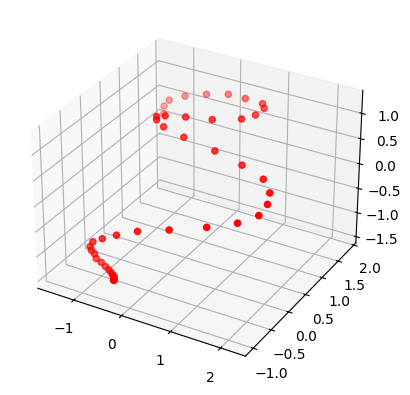

In [3]:
# Fonction de standardisation par trajectoire
def standardize_gesture(df_group):
    df = df_group.copy()
    # Standardisation pour les colonnes 'x', 'y', et 'z' : avec les noms de colonnes sans chevrons
    for axis in ['x', 'y', 'z']:
        df[f'{axis}_std'] = (df[axis] - df[axis].mean()) / df[axis].std()
    return df

# Appliquer la standardisation à chaque trajectoire
df = df.groupby(['subject', 'gesture', 'iter'], group_keys=False).apply(standardize_gesture)
#df = df.groupby(['gesture'], group_keys=False).apply(standardize_gesture)  #par geste uniquement


# Calculer le rang du temps 't' dans chaque groupe
df['t_rank'] = df.groupby(['subject', 'gesture', 'iter'])['t'].rank()

# Afficher les données normalisées d'une trajectoire en 3D
subdf = df.loc[(df['gesture'] == 3) & (df['subject'] == 2) & (df['iter'] == 10)]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(subdf['x_std'], subdf['y_std'], subdf['z_std'], c='r', marker='o')

# Statistiques descriptives
print(df.describe().transpose())

# Sauvegarde CSV
df.to_csv('df.csv', index=False)


In [4]:
#refaire un dico avec 100 ligne chaque fois pour deepL
def resample_gesture(df, target_len=100):
    resampled_data = []

    for (gesture, subject, iteration), group in df.groupby(['gesture', 'subject', 'iter']):
        original_len = len(group)
        original_indices = np.arange(original_len)
        target_indices = np.linspace(0, original_len - 1, target_len)

        if original_len < target_len:
            # Interpolation pour séquence courte
            interpolated_x = interp1d(original_indices, group['x_std'], kind='linear')(target_indices)
            interpolated_y = interp1d(original_indices, group['y_std'], kind='linear')(target_indices)
            interpolated_z = interp1d(original_indices, group['z_std'], kind='linear')(target_indices)

        elif original_len > target_len:
            # Sous-échantillonnage pour séquence longue
            interpolated_x = group['x_std'].iloc[target_indices.astype(int)].values
            interpolated_y = group['y_std'].iloc[target_indices.astype(int)].values
            interpolated_z = group['z_std'].iloc[target_indices.astype(int)].values

        else:
            # Exactement 100 points : on garde tel quel
            interpolated_x = group['x_std'].values
            interpolated_y = group['y_std'].values
            interpolated_z = group['z_std'].values

        resampled_df = pd.DataFrame({
            'gesture': [gesture] * target_len,
            'subject': [subject] * target_len,
            'iteration': [iteration] * target_len,
            'x_std': interpolated_x,
            'y_std': interpolated_y,
            'z_std': interpolated_z,
        })

        resampled_data.append(resampled_df)

    return pd.concat(resampled_data, ignore_index=True)

resample_gesture(df,100)




,gesture,subject,iteration,x_std,y_std,z_std
0,0,1,1,0.565989,0.836985,0.657603
1,0,1,1,0.561907,0.846208,0.665352
2,0,1,1,0.557968,0.846968,0.672419
3,0,1,1,0.550973,0.855382,0.679363
4,0,1,1,0.528174,0.855050,0.691699
...,...,...,...,...,...,...
99995,9,10,10,0.739647,-1.687634,-1.885653
99996,9,10,10,0.741800,-1.697436,-1.903142
99997,9,10,10,0.752100,-1.697934,-1.918776
99998,9,10,10,0.755892,-1.702077,-1.932252


In [5]:
def dict_creation_iterout(df, iter_out=10):
    # Séparation des données en test et train selon l'itération
    test_df = df[df["iter"] == iter_out]
    train_df = df[df["iter"] != iter_out]

    train_groups = train_df.groupby(["gesture", "subject", "iter"])
    test_groups = test_df.groupby(["gesture", "subject", "iter"])

    coord_dict_train = {}
    for (gesture, subject, _), group in train_groups:
        coords = group[["x_std", "y_std", "z_std"]].values.tolist()
        coord_dict_train.setdefault(gesture, []).append(coords)

    coord_dict_test = {}
    for (gesture, subject, _), group in test_groups:
        coords = group[["x_std", "y_std", "z_std"]].values.tolist()
        coord_dict_test.setdefault(gesture, []).append(coords)
    return coord_dict_train, coord_dict_test


def dict_creation_userout(df, subj_out):
    # Filtrage du sujet test
    test_df = df[df["subject"] == subj_out]
    
    # On garde seulement les 10 premières itérations par geste
    test_df = test_df[test_df["iter"] <= 10]

    # Données d'entraînement
    train_df = df[df["subject"] != subj_out]

    train_groups = train_df.groupby(["gesture", "subject", "iter"])
    test_groups = test_df.groupby(["gesture", "subject", "iter"])

    coord_dict_train = {}
    for (gesture, subject, _), group in train_groups:
        coords = group[["x_std", "y_std", "z_std"]].values.tolist()
        coord_dict_train.setdefault(gesture, []).append(coords)

    coord_dict_test = {}
    for (gesture, subject, _), group in test_groups:
        coords = group[["x_std", "y_std", "z_std"]].values.tolist()
        coord_dict_test.setdefault(gesture, []).append(coords)
    return coord_dict_train, coord_dict_test



In [6]:

# Distance Euclidienne 3D
def eucl_dist(list1, list2):
    return np.sqrt((list1[0] - list2[0])**2 + (list1[1] - list2[1])**2 + (list1[2] - list2[2])**2)

# Distance DTW
def dtw_dist(list1, list2):
    n = len(list1)
    m = len(list2)
    dtw_matrix = np.full((n+1, m+1), np.inf)
    dtw_matrix[0,0] = 0

    for i in range(1,n+1):
        for j in range(1,m+1):
            cost = eucl_dist(list1[i-1], list2[j-1])
            last_min = min(dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1])
            dtw_matrix[i, j] = cost + last_min

    return dtw_matrix[n,m]

# KNN avec affichage des voisins et votes
def knn_dtw_predict_verbose(reference_seq, train_dict, k=3):
    distances = []

    for gesture, sequences in train_dict.items():
        for seq in sequences:
            dist = dtw_dist(reference_seq, seq)
            distances.append((gesture, dist))

    distances.sort(key=lambda x: x[1])
    k_nearest_neighbors = distances[:k]

    #print(f"\nTop {k} voisins les plus proches (label, distance) :")
    #for i, (gesture, dist) in enumerate(k_nearest_neighbors):
        #print(f"  {i+1}. {gesture} — Distance DTW = {dist:.2f}")

    gestures = [gesture for gesture, _ in k_nearest_neighbors]
    vote_counts = Counter(gestures)

    print("\nVotes par classe :")
    for gesture, count in vote_counts.items():
        print(f"  {gesture} : {count} vote(s)")

    predicted_gesture = vote_counts.most_common(1)[0][0]
    return predicted_gesture



In [ ]:
def testmodel(DictCreationFunc, AlgoFunc, df, loop_range=10, k=3, title="Matrice de confusion des gestes"):
    total_true = []
    total_pred = []

    for i in range(loop_range):
        coord_dict_train, coord_dict_test = DictCreationFunc(df, i + 1)

        y_true = []
        y_pred = []

        for gesture, sequences in coord_dict_test.items():
            for seq in sequences:
                prediction = AlgoFunc(seq, coord_dict_train, k=k)

                if prediction is not None:
                    y_true.append(gesture)
                    y_pred.append(prediction)
                    total_true.append(gesture)
                    total_pred.append(prediction)
                    print(f"Vrai label : {gesture} — Prédiction : {prediction}")
                else:
                    print(f"Erreur de prédiction pour le geste {gesture}, séquence {seq}")

        correct = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)
        accuracy = correct / len(y_true) if y_true else 0
        print(f"\nExactitude pour itération {i+1} : {accuracy:.2%}")

    # Global accuracy
    correct = sum(1 for true, pred in zip(total_true, total_pred) if true == pred)
    accuracy = correct / len(total_true) if total_true else 0
    print(f"\n✅ Exactitude globale : {accuracy:.2%}")

    # Matrice de confusion
    labels = sorted(set(total_true + total_pred))
    cm = confusion_matrix(total_true, total_pred, labels=labels)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
    plt.title(title)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    return total_true, total_pred

testmodel(dict_creation_userout,knn_dtw_predict_verbose,df,10,5)



Votes par classe :
  0 : 5 vote(s)
Vrai label : 0 — Prédiction : 0
